Mount Google Drive

In [5]:
# Mount Google Drive (optional, if you want to save files)
#from google.colab import drive
#drive.mount('/content/drive')

# Install required packages
!pip install kagglehub numpy pandas matplotlib seaborn scikit-learn lightgbm tensorflow streamlit

In [7]:
!pip install kagglehub

Data from Kaggle

In [10]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("uciml/ct-slice-localization")
print("Path to dataset files:", path)


Path to dataset files: C:\Users\seanc\.cache\kagglehub\datasets\uciml\ct-slice-localization\versions\1


Data Loading and EDA

   patientId  value0  value1  value2  value3  value4  value5  value6  value7  \
0          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   
1          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   
2          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   
3          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   
4          0     0.0     0.0     0.0     0.0     0.0     0.0   -0.25   -0.25   

   value8  ...  value375  value376  value377  value378  value379  value380  \
0   -0.25  ...     -0.25  0.980381       0.0       0.0       0.0       0.0   
1   -0.25  ...     -0.25  0.977008       0.0       0.0       0.0       0.0   
2   -0.25  ...     -0.25  0.977008       0.0       0.0       0.0       0.0   
3   -0.25  ...     -0.25  0.977008       0.0       0.0       0.0       0.0   
4   -0.25  ...     -0.25  0.976833       0.0       0.0       0.0       0.0   

   value381  value382  value383  reference  
0    

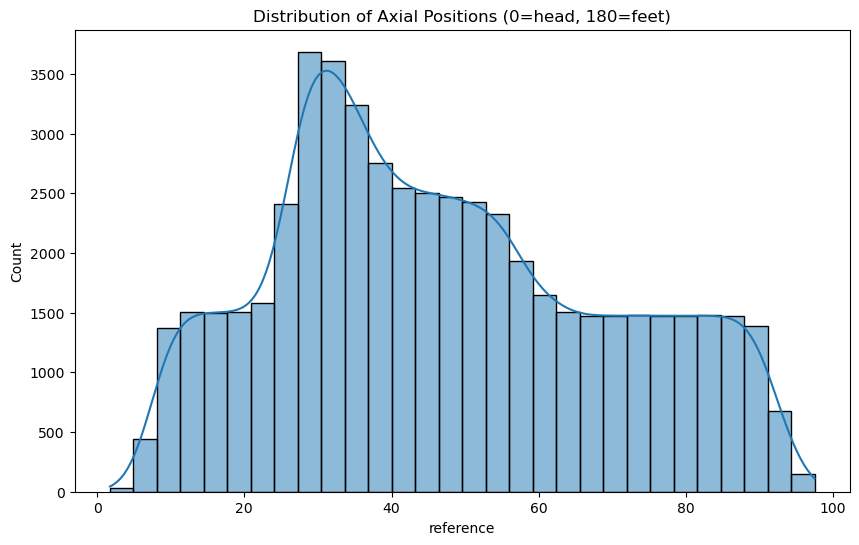

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("data/slice_localization_data.csv")

# Basic exploration
print(data.head())
print("\nData shape:", data.shape)
print("\nData info:")
print(data.info())
print("\nDescriptive statistics:")
print(data.describe())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Check target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['reference'], bins=30, kde=True)
plt.title('Distribution of Axial Positions (0=head, 180=feet)')
plt.show()

Data Preprocessing

In [14]:

# Data type

data.dtypes
data = data.apply(pd.to_numeric, errors='coerce').dropna()



In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Separate features and target
X = data.drop('reference', axis=1)
y = data['reference']

# Handle outliers (-0.25 values)
X = X.replace(-0.25, np.nan)




# Impute missing values (from outliers)
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

C:\Users\seanc\anaconda3\Lib\site-packages\sklearn\impute\_base.py:637: UserWarning: Skipping features without any observed values: ['value59' 'value69' 'value179' 'value189' 'value351']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Training set shape: (42800, 380)
Test set shape: (10700, 380)


Model Building and Evaluation

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    metrics = {
        'MAE_train': mean_absolute_error(y_train, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test),
        'RMSE_train': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'R2_train': r2_score(y_train, y_pred_train),
        'R2_test': r2_score(y_test, y_pred_test)
    }

    return metrics

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42)
}

# Evaluate each model
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"\n{name} Results:")
    print(pd.DataFrame(results[name], index=[name]))


Linear Regression Results:
                   MAE_train  MAE_test  RMSE_train  RMSE_test  R2_train  \
Linear Regression   6.543134   6.60492    8.734522   8.821952  0.847282   

                    R2_test  
Linear Regression  0.843926  

Random Forest Results:
               MAE_train  MAE_test  RMSE_train  RMSE_test  R2_train   R2_test
Random Forest    0.18859  0.463626    0.682974   1.625975  0.999066  0.994698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79264
[LightGBM] [Info] Number of data points in the train set: 42800, number of used features: 345
[LightGBM] [Info] Start training from score 47.010863

LightGBM Results:
          MAE_train  MAE_test  RMSE_train  RMSE_test  R2_train   R2_test
LightGBM   1.744563  1.919396    2.585401   2.937877   0.98662  0.982691


C:\Users\seanc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\seanc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Based on the result, *LightGBM shows the best balance of performance and generalization*

Hyperparameter Tuning (for best model)

6.1 Define Refined Parameter Grid

In [20]:
from sklearn.model_selection import GridSearchCV

# Focus on parameters that address overfitting and improve accuracy
param_grid = {
    'n_estimators': [200, 300],          # More trees for robustness
    'max_depth': [7, 10],                # Limit depth to prevent overfitting
    'learning_rate': [0.05, 0.1],        # Balance speed and accuracy
    'num_leaves': [63, 127],             # Controls complexity
    'min_child_samples': [20, 50],       # Regularization
    'reg_alpha': [0, 0.1],               # L1 regularization
    'reg_lambda': [0, 0.1]               # L2 regularization
}

6.2 Perform Grid Search

In [ ]:
# Initialize LightGBM with fixed random state
lgb_model = lgb.LGBMRegressor(random_state=42)

# Use MAE as scoring metric (matches your objective)
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=5,                                # 5-fold cross-validation
    scoring='neg_mean_absolute_error',   # Optimize for MAE
    n_jobs=-1,                           # Use all CPU cores
    verbose=1                            # Show progress
)

# Run grid search
grid_search.fit(X_train, y_train)

6.3 Evaluate the Best Model

In [69]:
import joblib
import pandas as pd

# Get the best estimator
best_lgb = grid_search.best_estimator_

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate on test set
y_pred = best_lgb.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nOptimized LightGBM Performance:")
print(f"- MAE: {mae:.4f} (Target: <1.92, previous best)")
print(f"- RMSE: {rmse:.4f}")
print(f"- R²: {r2:.4f}")

# Generate renamed columns based on X_test shape
renamed_columns = []
for i in range(X_test.shape[1]):
    if i < 241:
        renamed_columns.append(f"Bone Bin {i+1}")
    elif 241 <= i < 384:
        renamed_columns.append(f"Air Bin {i - 241 + 1}")
    else:
        renamed_columns.append(f"Bin {i+1}")

# Apply to X_test
X_test_named = pd.DataFrame(X_test, columns=renamed_columns)

# Save everything
joblib.dump(best_lgb, 'lightgbm_model.pkl')
joblib.dump(imputer, 'imputer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_test_named, "X_test.pkl")
joblib.dump(y_test.reset_index(drop=True), "y_test.pkl")
joblib.dump(renamed_columns, "feature_names.pkl")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 300, 'num_leaves': 127, 'reg_alpha': 0.1, 'reg_lambda': 0.1}

Optimized LightGBM Performance:
- MAE: 0.8477 (Target: <1.92, previous best)
- RMSE: 1.6797
- R²: 0.9943


C:\Users\seanc\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


['feature_names.pkl']

6.4 Compare with Baseline

In [65]:
# Calculate improvement over initial LightGBM
initial_mae = 1.9194
improvement = (initial_mae - mae) / initial_mae * 100

print(f"\nImprovement Over Initial LightGBM: {improvement:.2f}%")
if improvement >= 5:
    print("✅ Exceeds 5% improvement target!")
else:
    print("❌ Needs further tuning (try expanding parameter grid)")


Improvement Over Initial LightGBM: 55.84%
✅ Exceeds 5% improvement target!


6.5 Visualize Feature Importance

<Figure size 1000x800 with 0 Axes>

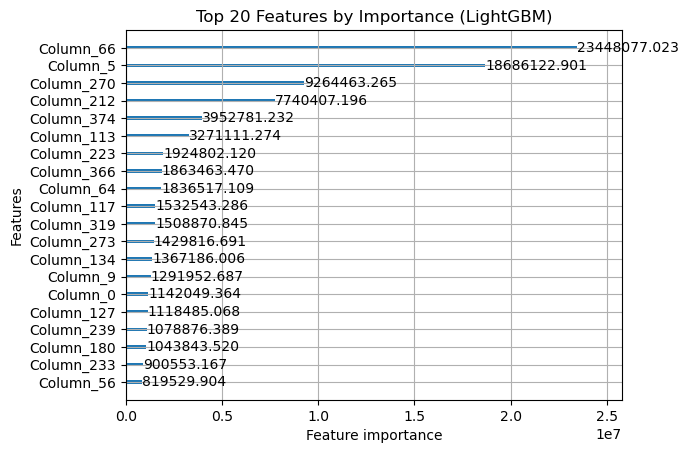

In [67]:
# Plot top 20 important features
plt.figure(figsize=(10, 8))
lgb.plot_importance(best_lgb, max_num_features=20, importance_type='gain')
plt.title('Top 20 Features by Importance (LightGBM)')
plt.show()